<a href="https://colab.research.google.com/github/kriskalb/celeba-image-attractiveness-prediction/blob/main/project_celebA_CV_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pyarrow

In [4]:
import warnings
import pyarrow.parquet as pq
warnings.simplefilter("ignore")

In [5]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
from scipy.stats import chi2_contingency
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Conv2D, BatchNormalization, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import SGD

import os
import zipfile
plt.style.use('ggplot')

%matplotlib inline

# Importing and extracting data - google colab

In [6]:
from google.colab import drive


drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
local_zip = '/content/drive/MyDrive/Kurs/projekt_CV/celeba_smaller.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [8]:
base_dir = '/tmp/celeba_smaller'
# sciezki
train_dir = os.path.join(base_dir, 'img_align_celeba_smaller/train')
validation_dir = os.path.join(base_dir, 'img_align_celeba_smaller/validation')

# Prediction of attractiveness based on a collection of CelebA celebrity photos

## Pre-preparation of labels and augmentation and preparation of images for the model using ImageDataGenerator

In [7]:
labels_train= pd.read_csv('/tmp/celeba_smaller/list_attr_celeba_smaller_train.csv')
labels_train.replace(-1, 0, inplace=True)
labels_validation= pd.read_csv('/tmp/celeba_smaller/list_attr_celeba_smaller_validation.csv')
labels_validation.replace(-1, 0, inplace=True)

In [8]:
parquet_file_path = '/content/drive/MyDrive/Kurs/projekt_CV/labels_train.parquet'
labels_train.to_parquet(parquet_file_path, engine='pyarrow')

In [9]:
parquet_file_path = '/content/drive/MyDrive/Kurs/projekt_CV/labels_validation.parquet'
labels_validation.to_parquet(parquet_file_path, engine='pyarrow')

Distribution of train and validation labels

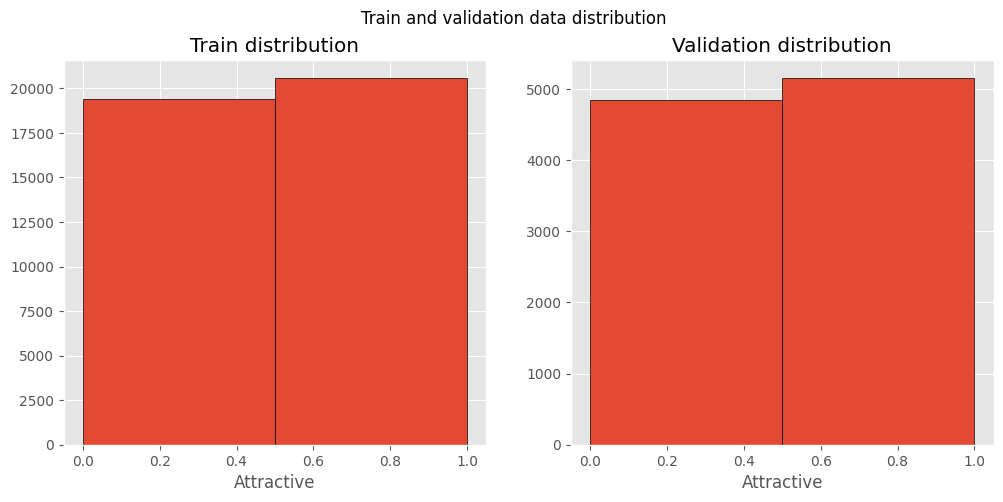

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(labels_train['Attractive'], bins=2, edgecolor='k')
axes[0].set_xlabel('Attractive')
axes[0].set_title('Train distribution')

axes[1].hist(labels_validation['Attractive'], bins=2, edgecolor='k')
axes[1].set_xlabel('Attractive')
axes[1].set_title('Validation distribution')

plt.suptitle('Train and validation data distribution')
plt.show()

In [10]:
labels_train['Attractive'] = labels_train['Attractive'].astype(str)
labels_validation['Attractive'] = labels_validation['Attractive'].astype(str)

In [11]:
IMG_WIDTH = 178
IMG_HEIGHT = 218

train_size = 40000
val_size = 10000

In [12]:
train_datagen  = ImageDataGenerator(rescale = 1/255,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.1,
                                    horizontal_flip=True)
val_datagen  = ImageDataGenerator(rescale = 1/255)

In [13]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=labels_train,
    directory=train_dir,
    x_col="image_id",
    y_col="Attractive",
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=64,  # Rozmiar batcha
    class_mode="binary",

)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=labels_validation,
    directory=validation_dir,
    x_col="image_id",
    y_col="Attractive",
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=64,
    class_mode="binary",

)

Found 40000 validated image filenames belonging to 2 classes.
Found 10000 validated image filenames belonging to 2 classes.


## Transfer learning - model InceptionV3

In [14]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)

predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_size // 64,
    epochs=3,
    validation_data=validation_generator,
    validation_steps=val_size // 64
)

87910968/87910968 [==============================] - 1s 0us/step
Epoch 1/3
625/625 [==============================] - 450s 692ms/step - loss: 0.5399 - accuracy: 0.7393 - val_loss: 0.4919 - val_accuracy: 0.7730
Epoch 2/3
625/625 [==============================] - 424s 678ms/step - loss: 0.4986 - accuracy: 0.7603 - val_loss: 0.4745 - val_accuracy: 0.7798
Epoch 3/3
625/625 [==============================] - 430s 688ms/step - loss: 0.4908 - accuracy: 0.7647 - val_loss: 0.4815 - val_accuracy: 0.7769


In [99]:
IMG_WIDTH = 178
IMG_HEIGHT = 218
train_size = 40000
val_size = 10000
epochs = 3
batch_size = 64
val_accuracy = 0.7798
val_loss = 0.4745

## Learning curve

In [15]:
def plot_history(history):
  plt.figure(figsize=(8,6))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend('Train loss', 'Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.figure(figsize=(8,6))
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.legend('Train accuracy', 'Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('accuracy')

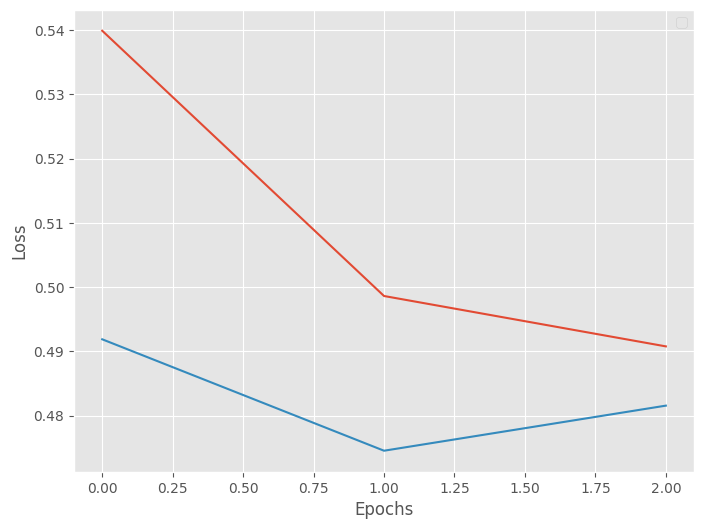

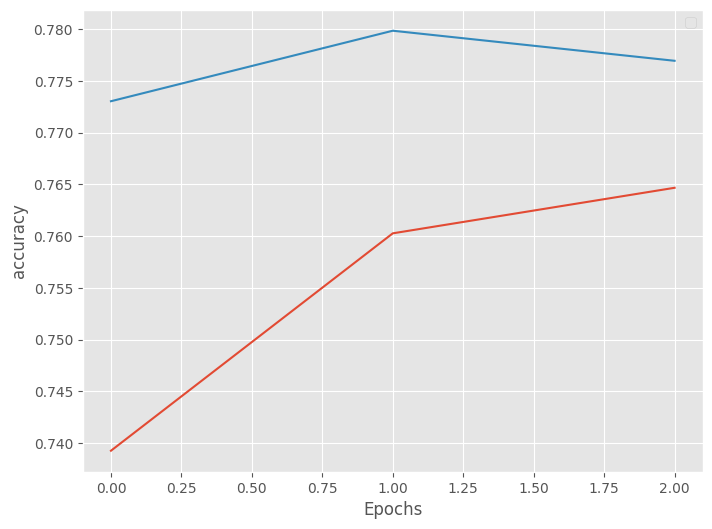

In [16]:
plot_history(history)

# Prediction of attractiveness based on dataset

In [9]:
df = pd.read_csv('/tmp/celeba_smaller/list_attr_celeba_smaller.csv')

In [10]:
parquet_file_path = '/content/drive/MyDrive/Kurs/projekt_CV/df_classification.parquet'
df.to_parquet(parquet_file_path, engine='pyarrow')

In [ ]:
parquet_file_path = '/content/drive/MyDrive/Kurs/projekt_CV/df_classification.parquet'
table = pq.read_table(parquet_file_path)
df = table.to_pandas()

In [11]:
df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [12]:
df.replace(-1, 0, inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   image_id             50000 non-null  object
 1   5_o_Clock_Shadow     50000 non-null  int64 
 2   Arched_Eyebrows      50000 non-null  int64 
 3   Attractive           50000 non-null  int64 
 4   Bags_Under_Eyes      50000 non-null  int64 
 5   Bald                 50000 non-null  int64 
 6   Bangs                50000 non-null  int64 
 7   Big_Lips             50000 non-null  int64 
 8   Big_Nose             50000 non-null  int64 
 9   Black_Hair           50000 non-null  int64 
 10  Blond_Hair           50000 non-null  int64 
 11  Blurry               50000 non-null  int64 
 12  Brown_Hair           50000 non-null  int64 
 13  Bushy_Eyebrows       50000 non-null  int64 
 14  Chubby               50000 non-null  int64 
 15  Double_Chin          50000 non-null  int64 
 16  Eyeg

In [14]:
for column in df.columns[1:]:
  df[column] = df[column].astype('int16')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   image_id             50000 non-null  object
 1   5_o_Clock_Shadow     50000 non-null  int16 
 2   Arched_Eyebrows      50000 non-null  int16 
 3   Attractive           50000 non-null  int16 
 4   Bags_Under_Eyes      50000 non-null  int16 
 5   Bald                 50000 non-null  int16 
 6   Bangs                50000 non-null  int16 
 7   Big_Lips             50000 non-null  int16 
 8   Big_Nose             50000 non-null  int16 
 9   Black_Hair           50000 non-null  int16 
 10  Blond_Hair           50000 non-null  int16 
 11  Blurry               50000 non-null  int16 
 12  Brown_Hair           50000 non-null  int16 
 13  Bushy_Eyebrows       50000 non-null  int16 
 14  Chubby               50000 non-null  int16 
 15  Double_Chin          50000 non-null  int16 
 16  Eyeg

In [16]:
parquet_file_path = '/content/drive/MyDrive/Kurs/projekt_CV/df_classification.parquet'
table = pq.read_table(parquet_file_path)
df = table.to_pandas()

In [19]:
columns_to_chi2 = list(df.columns[1:3]) + list(df.columns[4:])
columns_to_chi2

['5_o_Clock_Shadow',
 'Arched_Eyebrows',
 'Bags_Under_Eyes',
 'Bald',
 'Bangs',
 'Big_Lips',
 'Big_Nose',
 'Black_Hair',
 'Blond_Hair',
 'Blurry',
 'Brown_Hair',
 'Bushy_Eyebrows',
 'Chubby',
 'Double_Chin',
 'Eyeglasses',
 'Goatee',
 'Gray_Hair',
 'Heavy_Makeup',
 'High_Cheekbones',
 'Male',
 'Mouth_Slightly_Open',
 'Mustache',
 'Narrow_Eyes',
 'No_Beard',
 'Oval_Face',
 'Pale_Skin',
 'Pointy_Nose',
 'Receding_Hairline',
 'Rosy_Cheeks',
 'Sideburns',
 'Smiling',
 'Straight_Hair',
 'Wavy_Hair',
 'Wearing_Earrings',
 'Wearing_Hat',
 'Wearing_Lipstick',
 'Wearing_Necklace',
 'Wearing_Necktie',
 'Young']

In [ ]:
df

In [27]:
columns_to_model = []
for column in columns_to_chi2:
  contingency_table = pd.crosstab(df[column], df['Attractive'])
  chi2, p, dof, expected = chi2_contingency(contingency_table)
  if p <0.01:
    print(f"Chi-squared for {column}:\t {chi2} \tP-value for {column}:\t {p}")
    columns_to_model.append(column)

Chi-squared for 5_o_Clock_Shadow:	 228.974095075488 	P-value for 5_o_Clock_Shadow:	 9.978780498825324e-52
Chi-squared for Arched_Eyebrows:	 3317.0882908198946 	P-value for Arched_Eyebrows:	 0.0
Chi-squared for Bags_Under_Eyes:	 1484.0426438825975 	P-value for Bags_Under_Eyes:	 0.0
Chi-squared for Bald:	 1072.8741671894552 	P-value for Bald:	 2.597744998858955e-235
Chi-squared for Bangs:	 221.77514468507204 	P-value for Bangs:	 3.7083966493205567e-50
Chi-squared for Big_Lips:	 230.3708373604834 	P-value for Big_Lips:	 4.9484526436307325e-52
Chi-squared for Big_Nose:	 4020.6610771098804 	P-value for Big_Nose:	 0.0
Chi-squared for Blond_Hair:	 1148.5629936660093 	P-value for Blond_Hair:	 9.208740137840858e-252
Chi-squared for Blurry:	 1665.8889779902152 	P-value for Blurry:	 0.0
Chi-squared for Brown_Hair:	 975.8014014483495 	P-value for Brown_Hair:	 3.2676337390900685e-214
Chi-squared for Bushy_Eyebrows:	 79.7768665304099 	P-value for Bushy_Eyebrows:	 4.1917188689429307e-19
Chi-squared f

In [38]:
columns_to_corr = ['Attractive'] + columns_to_model

In [39]:
df_to_corr = df[columns_to_corr]

In [36]:
import numpy as np
import scipy.stats as stats

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    cramers_v = np.sqrt(chi2 / (n * min(k - 1, r - 1)))

    return cramers_v

In [42]:
correlation_matrix = np.zeros((len(df_to_corr.columns), len(df_to_corr.columns)))

for i, var1 in enumerate(df_to_corr.columns):
    for j, var2 in enumerate(df_to_corr.columns):
        cramers_v_score = cramers_v(df_to_corr[var1], df_to_corr[var2])
        correlation_matrix[i, j] = cramers_v_score

correlation_matrix = pd.DataFrame(correlation_matrix, columns=df_to_corr.columns, index=df_to_corr.columns)

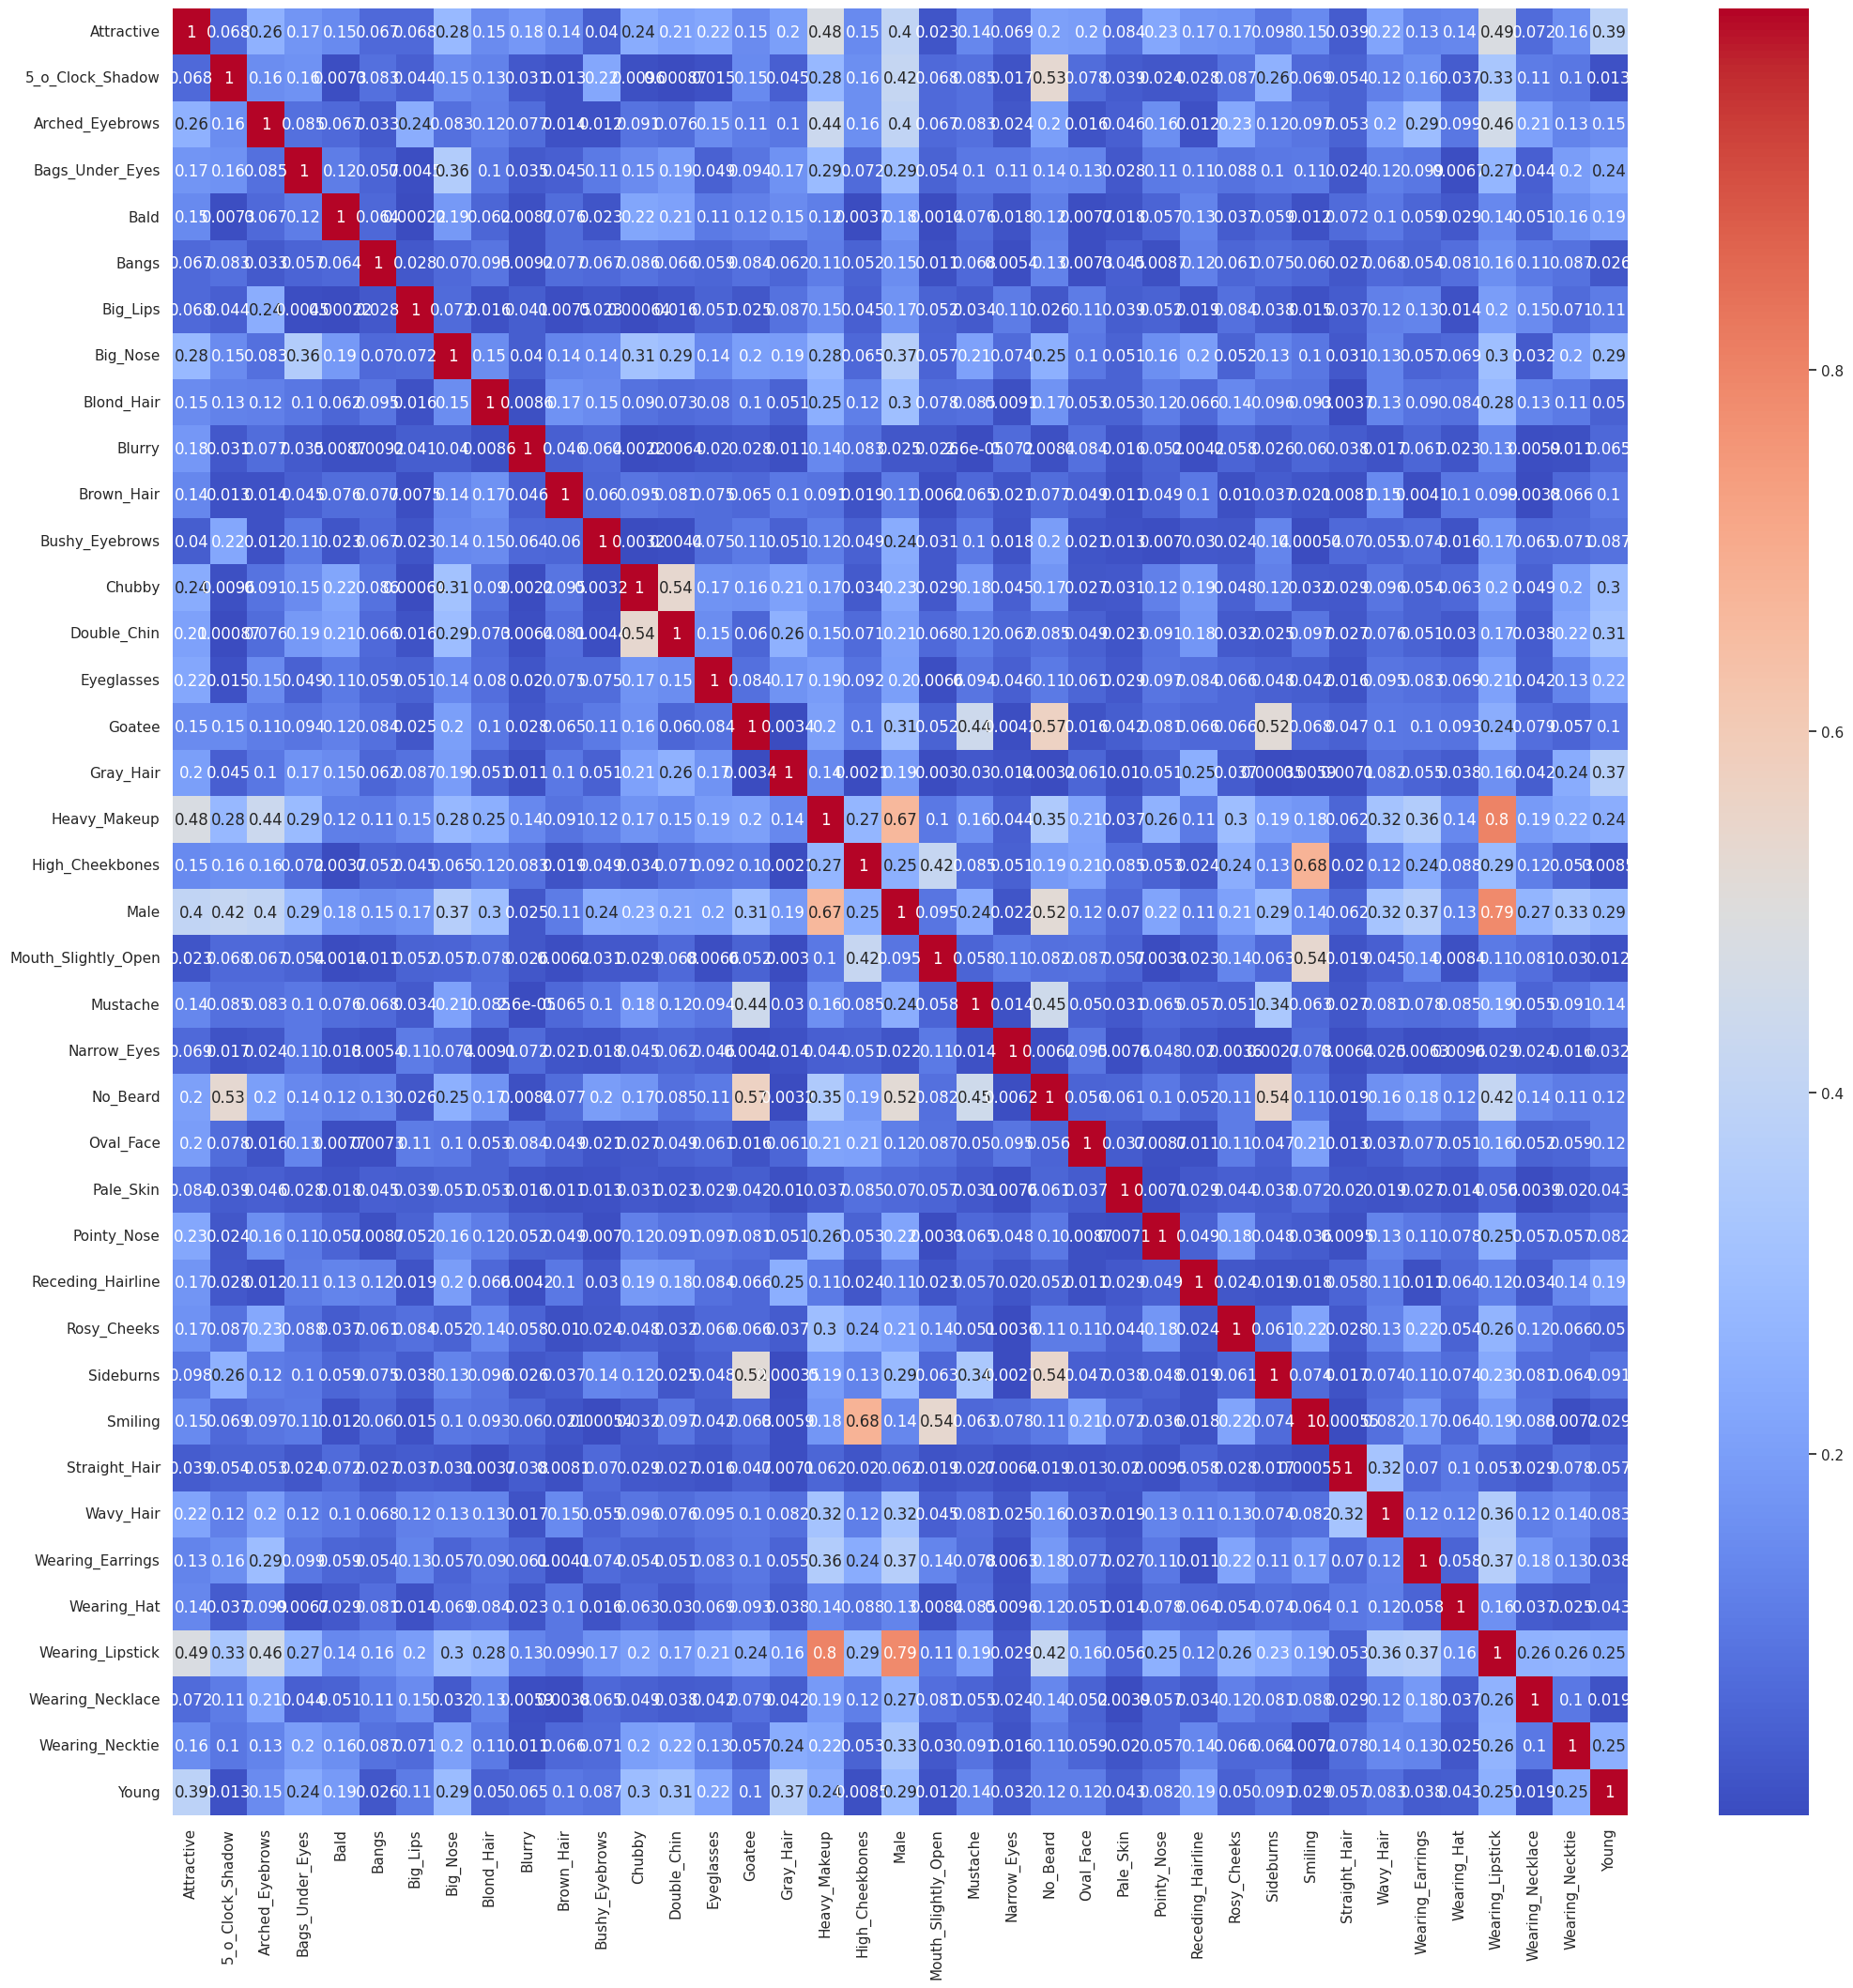

In [46]:
import seaborn as sns

plt.figure(figsize = (25,25))
color_palette = 'coolwarm'
sns.heatmap(correlation_matrix, annot = True,cmap=color_palette)
plt.show()

In [54]:
corr_attractive = correlation_matrix['Attractive']
corr_attractive[abs(corr_attractive)>0.14]

Attractive           0.999960
Arched_Eyebrows      0.257569
Bags_Under_Eyes      0.172281
Bald                 0.146484
Big_Nose             0.283572
Blond_Hair           0.151563
Blurry               0.182532
Chubby               0.238520
Double_Chin          0.207494
Eyeglasses           0.223837
Goatee               0.151658
Gray_Hair            0.201305
Heavy_Makeup         0.482369
High_Cheekbones      0.148435
Male                 0.404227
Mustache             0.140480
No_Beard             0.203892
Oval_Face            0.195677
Pointy_Nose          0.225835
Receding_Hairline    0.174956
Rosy_Cheeks          0.166295
Smiling              0.147219
Wavy_Hair            0.217676
Wearing_Hat          0.140488
Wearing_Lipstick     0.487523
Wearing_Necktie      0.156031
Young                0.387337
Name: Attractive, dtype: float64

In [56]:
labels_x = list(correlation_matrix['Attractive'][abs(corr_attractive)>0.14].index)
labels_x

['Attractive',
 'Arched_Eyebrows',
 'Bags_Under_Eyes',
 'Bald',
 'Big_Nose',
 'Blond_Hair',
 'Blurry',
 'Chubby',
 'Double_Chin',
 'Eyeglasses',
 'Goatee',
 'Gray_Hair',
 'Heavy_Makeup',
 'High_Cheekbones',
 'Male',
 'Mustache',
 'No_Beard',
 'Oval_Face',
 'Pointy_Nose',
 'Receding_Hairline',
 'Rosy_Cheeks',
 'Smiling',
 'Wavy_Hair',
 'Wearing_Hat',
 'Wearing_Lipstick',
 'Wearing_Necktie',
 'Young']

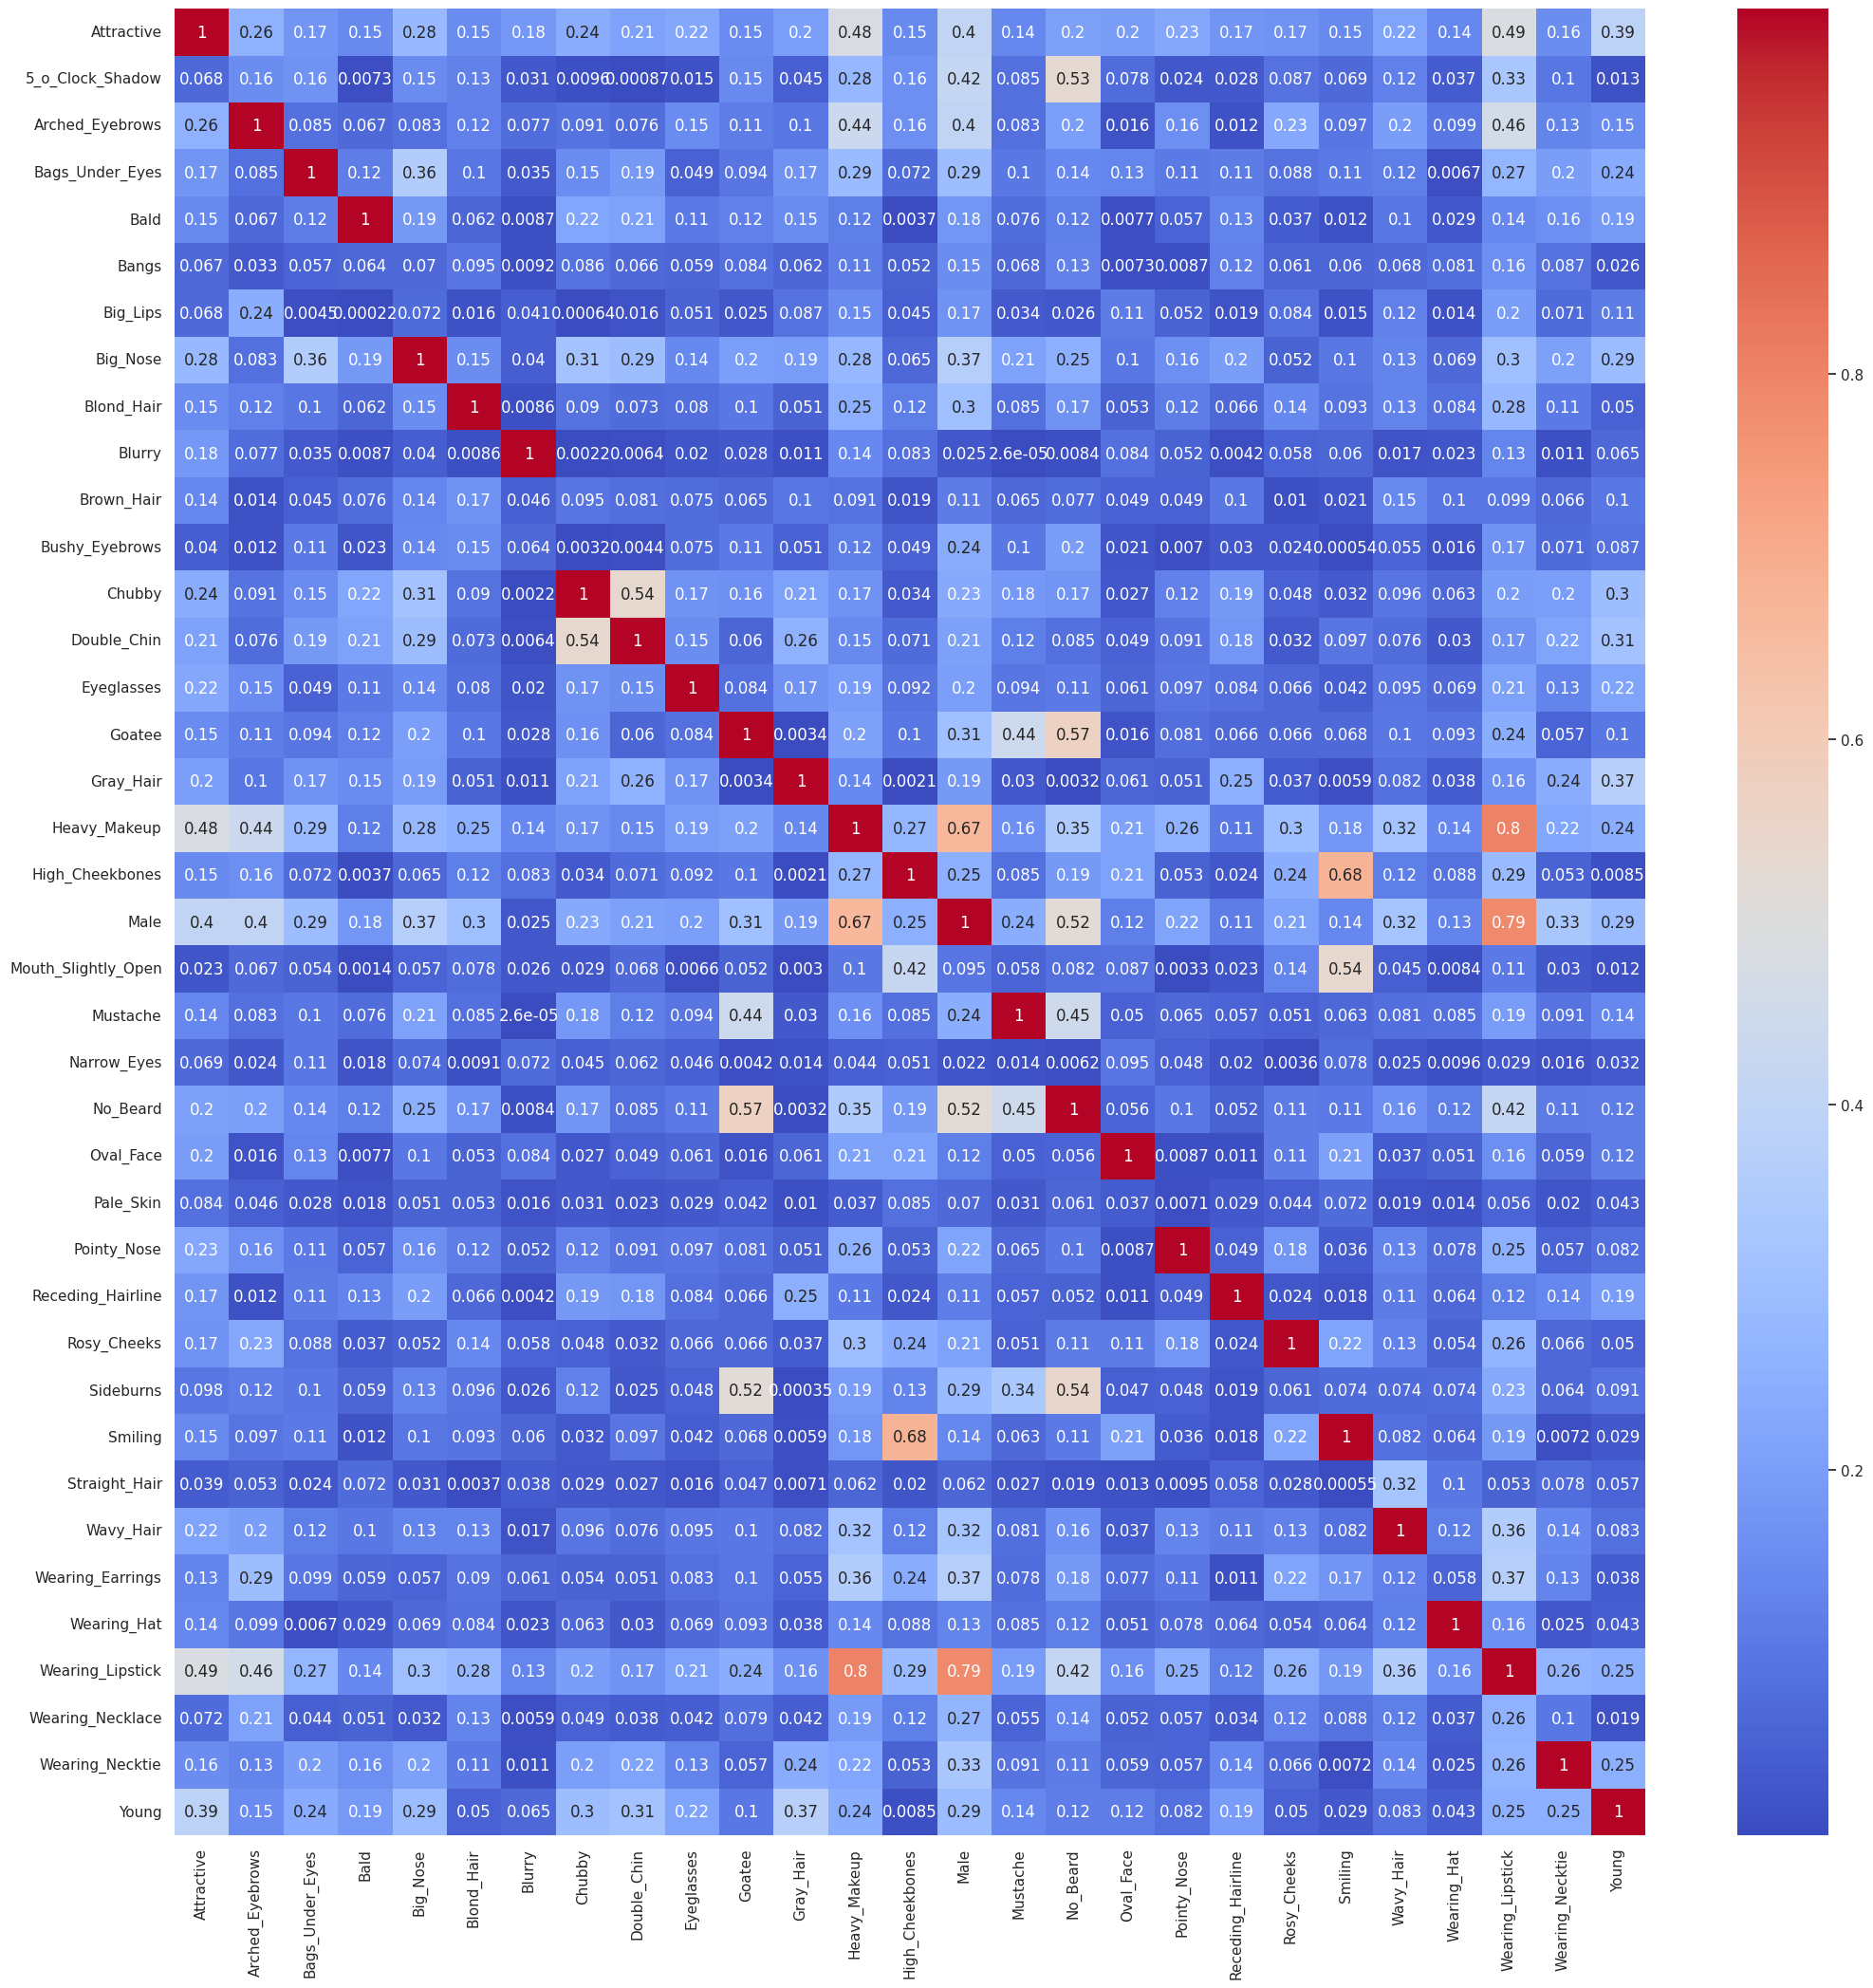

In [57]:
labels_x = list(correlation_matrix['Attractive'][abs(corr_attractive)>0.14].index)
plt.figure(figsize = (25,25))
color_palette = 'coolwarm'
sns.heatmap(correlation_matrix[labels_x], annot = True,cmap=color_palette)
plt.show()

## Models

In [69]:
!pip install xgboost
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.7 MB/s eta 0:00:00


In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
import xgboost as xgb
import optuna

In [65]:
del labels_x[labels_x.index("Attractive")]
X_train = df[labels_x][:40000]
X_test = df[labels_x][40000:]
y_train = df['Attractive'][:40000]
y_test = df['Attractive'][40000:]

In [66]:
def run_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Accuracy_score for model {model.__class__.__name__}:\t {accuracy}\t\t F1_score \t{f1} ")

In [67]:
log_model_l2 = LogisticRegression(penalty='l2')
svc_model = SVC(C=10, kernel='linear')
knn_model = KNeighborsClassifier()
dt_model = DecisionTreeClassifier()
rf_model = RandomForestClassifier()

for model in [log_model_l2, svc_model, knn_model, dt_model, rf_model]:
    run_model(model)

Accuracy_score for model LogisticRegression:	 0.7809		 F1_score 	0.7903549899531145 
Accuracy_score for model SVC:	 0.7687		 F1_score 	0.7661510464058234 
Accuracy_score for model KNeighborsClassifier:	 0.7397		 F1_score 	0.75505787145949 
Accuracy_score for model DecisionTreeClassifier:	 0.762		 F1_score 	0.7734627831715211 
Accuracy_score for model RandomForestClassifier:	 0.7666		 F1_score 	0.7791027825099376 


### Logistic Regression

In [101]:
log_model_l2 = LogisticRegression(penalty='l2', solver='liblinear')
log_model_l1 = LogisticRegression(penalty='l1', solver='liblinear')
log_model_elastic = LogisticRegression(penalty='elasticnet', l1_ratio=0.5, C=1.0, solver='saga')

In [102]:
log_model_l2.fit(X_train, y_train)
log_model_l1.fit(X_train, y_train)
log_model_elastic.fit(X_train, y_train)

LogisticRegression(l1_ratio=0.5, penalty='elasticnet', solver='saga')

In [103]:
y_pred_l2 = log_model_l2.predict(X_test)
y_pred_l1 = log_model_l1.predict(X_test)
y_pred_elastic = log_model_elastic.predict(X_test)

In [104]:
accuracy_l2 = accuracy_score(y_test, y_pred_l2)
f1_l2 = f1_score(y_test, y_pred_l2)
accuracy_l1 = accuracy_score(y_test, y_pred_l1)
f1_l1 = f1_score(y_test, y_pred_l1)
accuracy_elastic = accuracy_score(y_test, y_pred_elastic)
f1_elastic = f1_score(y_test, y_pred_elastic)

In [105]:
print(f'Logistic regression - Ridge regularization:\taccuracy: {accuracy_l2}\tf1_score: {f1_l2}')
print(f'Logistic regression - Lasso regularization:\taccuracy: {accuracy_l1}\tf1_score: {f1_l1}')
print(f'Logistic regression - ElasticNet regularization:\taccuracy: {accuracy_elastic}\tf1_score: {f1_elastic}')

Logistic regression - Ridge regularization:	accuracy: 0.7808	f1_score: 0.7896353166986564
Logistic regression - Lasso regularization:	accuracy: 0.7807	f1_score: 0.7895595432300163
Logistic regression - ElasticNet regularization:	accuracy: 0.7809	f1_score: 0.7903549899531145


### Decission tree classifier

In [84]:
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 3, 15)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)

    model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

In [85]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

[I 2023-10-15 11:36:27,515] A new study created in memory with name: no-name-6bbba757-2d21-4ae7-9308-c0beb4c84df3
[I 2023-10-15 11:36:27,641] Trial 0 finished with value: 0.755 and parameters: {'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.755.
[I 2023-10-15 11:36:27,801] Trial 1 finished with value: 0.779 and parameters: {'max_depth': 12, 'min_samples_split': 16, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.779.
[I 2023-10-15 11:36:27,970] Trial 2 finished with value: 0.7805 and parameters: {'max_depth': 10, 'min_samples_split': 17, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.7805.
[I 2023-10-15 11:36:28,119] Trial 3 finished with value: 0.7796 and parameters: {'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.7805.
[I 2023-10-15 11:36:28,211] Trial 4 finished with value: 0.7701 and parameters: {'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 

In [86]:
best_params = study.best_params
best_accuracy = study.best_value

best_tree_model = DecisionTreeClassifier(**best_params)
best_tree_model.fit(X_train, y_train)

y_pred = best_tree_model.predict(X_test)
accuracy_tree = accuracy_score(y_test, y_pred)
f1_tree = f1_score(y_test, y_pred)

print("Best params:", best_params)
print("Best accuracy:", accuracy_tree)
print("Best f1_score:", f1_tree)

Best params: {'max_depth': 11, 'min_samples_split': 12, 'min_samples_leaf': 10}
Best accuracy: 0.7821
Best f1_score: 0.7964882786961801


### Random Forest Classification

In [78]:
def objective(trial):
    n_estimators = trial.suggest_categorical('n_estimators', [180, 190, 200, 210, 220, 230, 240, 250])
    max_depth = trial.suggest_int('max_depth', 3, 15)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

In [79]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

[I 2023-10-15 11:05:30,518] A new study created in memory with name: no-name-b897c48a-4dfd-49cd-902b-ef745b65eaf9
[I 2023-10-15 11:05:33,805] Trial 0 finished with value: 0.779 and parameters: {'n_estimators': 230, 'max_depth': 9, 'min_samples_split': 14, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.779.
[I 2023-10-15 11:05:36,896] Trial 1 finished with value: 0.7796 and parameters: {'n_estimators': 220, 'max_depth': 9, 'min_samples_split': 20, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.7796.
[I 2023-10-15 11:05:41,319] Trial 2 finished with value: 0.7791 and parameters: {'n_estimators': 230, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.7796.
[I 2023-10-15 11:05:48,691] Trial 3 finished with value: 0.7815 and parameters: {'n_estimators': 190, 'max_depth': 14, 'min_samples_split': 18, 'min_samples_leaf': 13}. Best is trial 3 with value: 0.7815.
[I 2023-10-15 11:05:50,459] Trial 4 finished with value: 0.7557 and paramet

In [83]:
best_params = study.best_params
best_accuracy = study.best_value

best_rf_model = RandomForestClassifier(**best_params)
best_rf_model.fit(X_train, y_train)

y_pred = best_rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred)
f1_rf = f1_score(y_test, y_pred)

print("Best params:", best_params)
print("Best accuracy:", accuracy_rf)
print("Best f1_score:", f1_rf)

Best params: {'n_estimators': 230, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 4}
Best accuracy: 0.7853
Best f1_score: 0.7956211327939077


### Adaboost

In [94]:
from sklearn.ensemble import AdaBoostClassifier

ada_model = AdaBoostClassifier(n_estimators=200, random_state=42)
ada_model.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=200, random_state=42)

In [95]:
y_pred = ada_model.predict(X_test)
accuracy_ada = accuracy_score(y_test, y_pred)
f1_ada = f1_score(y_test, y_pred)

print("Adaboost accuracy:", accuracy_ada)
print("Adaboost f1_score:", f1_ada)

Best accuracy: 0.7796
Best f1_score: 0.7897347834382751


### SVC model

In [97]:
svc_model = SVC(C=100, kernel='linear')
svc_model.fit(X_train, y_train)

SVC(C=100, kernel='linear')

In [100]:
y_pred = svc_model.predict(X_test)
accuracy_svc = accuracy_score(y_test, y_pred)
f1_svc = f1_score(y_test, y_pred)
print("SVC accuracy:", accuracy_svc)
print("SVC f1_score:", f1_svc)

SVC accuracy: 0.7684
SVC f1_score: 0.7657766990291263


# Summary

In [116]:
print(f'InceptionV3 model for imageset of 50000 images ({IMG_HEIGHT}:{IMG_WIDTH} shape)\naccuracy score on validation set:\t{val_accuracy}\nloss on validation set:\t\t\t{val_loss}')

InceptionV3 model for imageset of 50000 images (218:178 shape)
accuracy score on validation set:	0.7798
loss on validation set:			0.4745


In [113]:
print(f'Logistic Regression model:\taccuracy:\t{accuracy_elastic}\t\tf1_score:\t{f1_elastic}')
print(f'Decission Tree model:\t\taccuracy:\t{accuracy_tree}\t\tf1_score:\t{f1_tree}')
print(f'Random Forest model:\t\taccuracy:\t{accuracy_rf}\t\tf1_score:\t{f1_rf}')
print(f'Adaboost model:\t\t\taccuracy:\t{accuracy_ada}\t\tf1_score:\t{f1_ada}')
print(f'Support Vector model:\t\taccuracy:\t{accuracy_svc}\t\tf1_score:\t{f1_svc}')

Logistic Regression model:	accuracy:	0.7809		f1_score:	0.7903549899531145
Decission Tree model:		accuracy:	0.7821		f1_score:	0.7964882786961801
Random Forest model:		accuracy:	0.7853		f1_score:	0.7956211327939077
Adaboost model:			accuracy:	0.7796		f1_score:	0.7897347834382751
Support Vector model:		accuracy:	0.7684		f1_score:	0.7657766990291263
